# [FAISS with Text](https://medium.com/loopio-tech/how-to-use-faiss-to-build-your-first-similarity-search-bf0f708aa772)

## Sequence Diagram
- The steps above are summarized in this diagram.

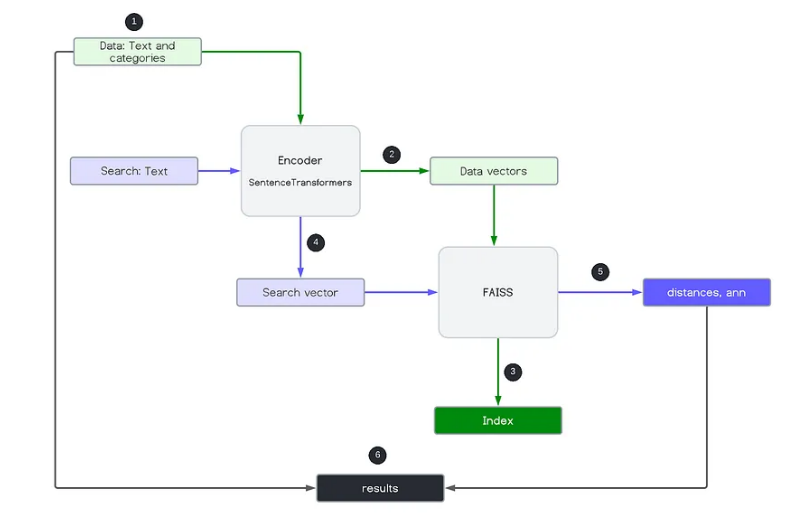

## Step 0: Install

In [ ]:
!pip install faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.4 MB/s eta 0:00:00


## Step 1: Create a dataframe with the existing text and categories
- Here we have a few sentences categorized into 3 unique labels: `location`, `random`, and `networking`.

In [ ]:
import pandas as pd

data = [['Where are your headquarters located?', 'location'],
['Throw my cellphone in the water', 'random'],
['Network Access Control?', 'networking'],
['Address', 'location']]

df = pd.DataFrame(data, columns = ['text', 'category'])
df.head()

,text,category
0,Where are your headquarters located?,location
1,Throw my cellphone in the water,random
2,Network Access Control?,networking
3,Address,location


## Step 2: Create vectors from the text
- Using the text column of the dataframe, word embeddings or vectors are generated for each row using the `Sentence Transformers framework`.
- This is just one of the libraries available for transformation among others like doc2vec.

In [ ]:
from sentence_transformers import SentenceTransformer

text = df['text']
encoder = SentenceTransformer("paraphrase-mpnet-base-v2")
vectors = encoder.encode(text)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Step 3: Build a FAISS index from the vectors
- Using the dimension of the vector (768 in this case), an L2 distance index is created, and L2 normalized vectors are added to that index.
- In FAISS, an index is an object that makes similarity searching efficient.

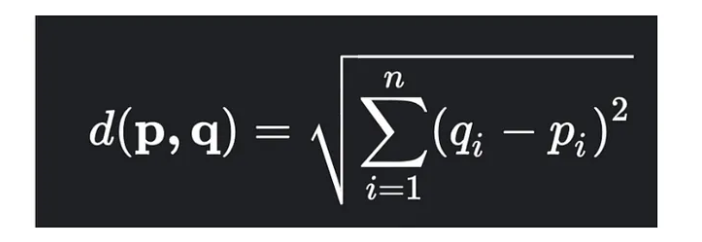

In [ ]:
import faiss

vector_dimension = vectors.shape[1]
index = faiss.IndexFlatL2(vector_dimension)

faiss.normalize_L2(vectors)
index.add(vectors)

## Step 4: Create a search vector
- Let’s say we now want to search for the sentence that is most similar to our search text ‘where is your office?’.
- Using the same method of vectorization from step 2, a search text is transformed.
- Then the vector is also normalized because all the vectors within the search index are normalized.

In [ ]:
import numpy as np

search_text = 'where is your office?'
search_vector = encoder.encode(search_text)

_vector = np.array([search_vector])
faiss.normalize_L2(_vector)

## Step 5: Search
- In this case, we want to search for all nearest neighbours, so k is set to the total number of vectors within the index.

In [ ]:
k = index.ntotal
distances, ann = index.search(_vector, k=k)

## Step 6: Sort search results
- In this dataframe, you can see that the distances are sorted in an ascending order.
- The ann is the approximate nearest neighbour corresponding to that distance, meaning that ann 0 is the vector at position 0 in the index.
- Similarly, ann 3 is the vector at position 3 in the index — based on the order of text vectors from step 1.

In [ ]:
results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})
results

,distances,ann
0,0.584872,0
1,1.175950,3
2,1.644265,2
3,1.919768,1


## Step 7: Get category for the search text
- Similar vectors are defined as those that are nearby in Euclidean space.
- If we were to pair the distances and ann dataframe with the dataframe in step 1:

In [ ]:
# join yb: df1.ann == data.index
merge = pd.merge(results, df, left_on='ann', right_index=True)
merge

,distances,ann,text,category
0,0.584872,0,Where are your headquarters located?,location
1,1.175950,3,Address,location
2,1.644265,2,Network Access Control?,networking
3,1.919768,1,Throw my cellphone in the water,random


- We can see that text “Where are your headquarters located?” has the shortest distance of 0.5848729 from our search text “Where is your office?”.
- We can thus retrieve the category as the category at the position with the lowest distance:

In [ ]:
labels  = df['category']
category = labels[ann[0][0]]

print(f"labels > {labels}")
print(f"category > {category}")

labels > 0      location
1        random
2    networking
3      location
Name: category, dtype: object
category > location


# [FAISS with langchain](https://wikidocs.net/234014)

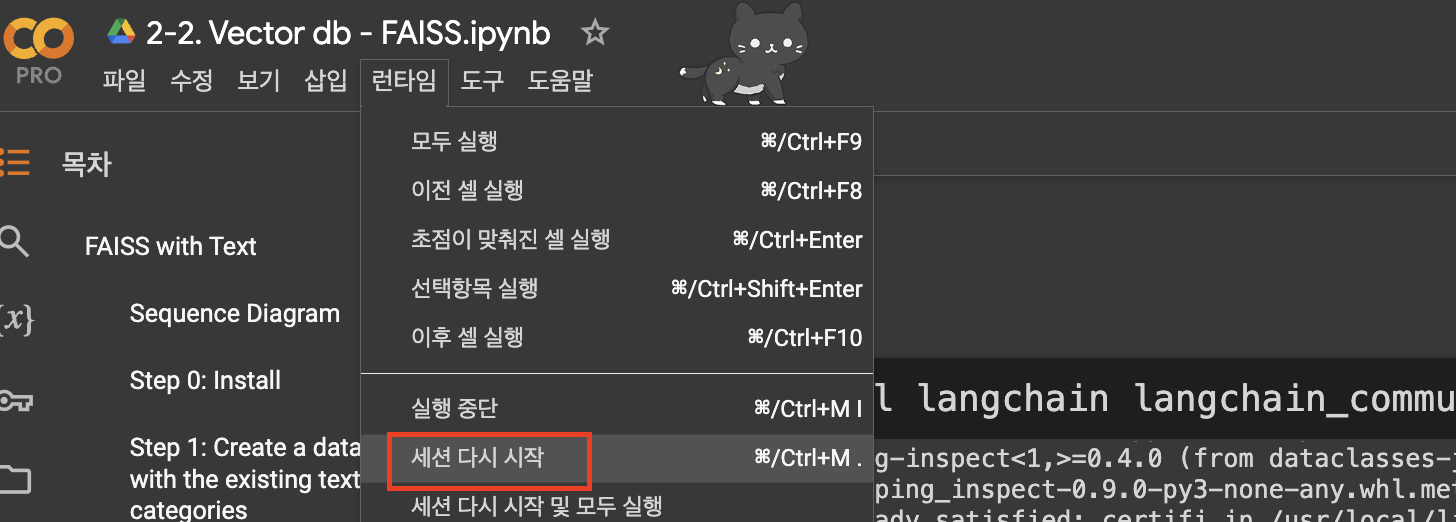

## 설치

In [ ]:
!pip install langchain langchain_openai langchain_community openai faiss-cpu sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 788.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.2/396.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

### [OPENAI_API_KEY](https://platform.openai.com/docs/overview)

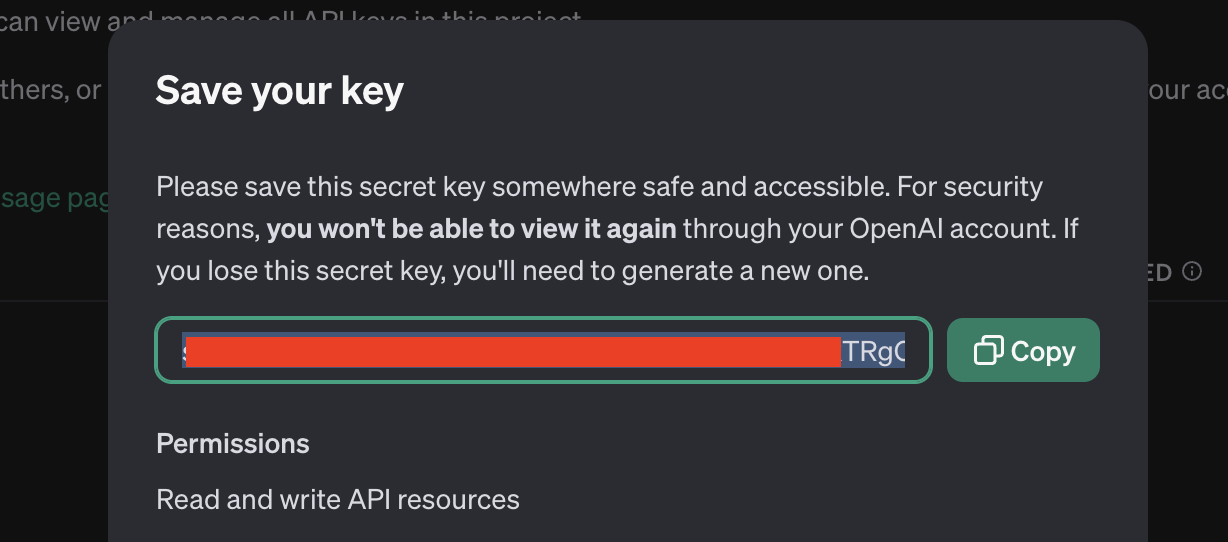

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = '생성한 키 입력'

## 샘플 데이터셋을 로드

### 구글 드라이브 연결

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive

drive.mount('/content/data')

Mounted at /content/data


In [ ]:
DATA_PATH = "/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/vector_db/"

### TextLoader

In [ ]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=0)

# 텍스트 파일을 load -> List[Document] 형태로 변환
loader1 = TextLoader(DATA_PATH+"nlp-keywords.txt")
loader2 = TextLoader(DATA_PATH+"finance-keywords.txt")

# 문서 분할
split_doc1 = loader1.load_and_split(text_splitter)
split_doc2 = loader2.load_and_split(text_splitter)

# 문서 개수 확인
len(split_doc1), len(split_doc2)

(11, 6)

## VectorStore 생성
- FAISS는 고성능 벡터 검색 및 클러스터링을 위한 라이브러리입니다.
- 이 클래스는 FAISS를 LangChain의 VectorStore 인터페이스와 통합합니다.
- 임베딩 함수, FAISS 인덱스, 문서 저장소를 조합하여 효율적인 벡터 검색 시스템을 구축할 수 있습니다.

### 주요 초기화 매개변수

- 인덱싱 매개변수:
  - `embedding_function (Embeddings)`: 사용할 임베딩 함수
- 클라이언트 매개변수:
  - `index (Any)`: 사용할 FAISS 인덱스
  - `docstore (Docstore)`: 사용할 문서 저장소
  - `index_to_docstore_id (Dict[int, str])`: 인덱스에서 문서 저장소 ID로의 매핑

In [ ]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_openai import OpenAIEmbeddings

# 임베딩
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 임베딩 차원 크기를 계산
dimension_size = len(embeddings.embed_query("hello world"))
print(dimension_size)

1536


In [ ]:
# FAISS 벡터 저장소 생성
db = FAISS(
    embedding_function=embeddings,
    index=faiss.IndexFlatL2(dimension_size),
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

### FAISS 벡터 저장소 생성 (from_documents)
- `from_documents` 클래스 메서드는 문서 리스트와 임베딩 함수를 사용하여 FAISS 벡터 저장소를 생성합니다.
- 이 메서드는 `from_texts` 메서드를 내부적으로 호출하여 벡터 저장소를 생성합니다.
- 문서의 `page_content`는 텍스트로, `metadata`는 메타데이터로 사용됩니다.
- 추가적인 설정이 필요한 경우 `kwargs`를 통해 전달할 수 있습니다.

- 매개변수
  - `documents (List[Document])`: 벡터 저장소에 추가할 문서 리스트
  - `embedding (Embeddings)`: 사용할 임베딩 함수
  - `**kwargs`: 추가 키워드 인자
- 동작 방식
  - 문서 리스트에서 텍스트 내용(page_content)과 메타데이터를 추출합니다.
  - 추출한 텍스트와 메타데이터를 사용하여 from_texts 메서드를 호출합니다.
- 반환값
  - `VectorStore`: 문서와 임베딩으로 초기화된 벡터 저장소 인스턴스

In [ ]:
# DB 생성
db = FAISS.from_documents(documents=split_doc1, embedding=OpenAIEmbeddings())

In [ ]:
# 문서 저장소 ID 확인
db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d'}

In [ ]:
# 저장된 문서의 ID: Document 확인
db.docstore._dict

{'5eafff34-b65c-4ca9-81f5-d1302fa0032a': Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='Semantic Search\n\n정의: 의미론적 검색은 사용자의 질의를 단순한 키워드 매칭을 넘어서 그 의미를 파악하여 관련된 결과를 반환하는 검색 방식입니다.\n예시: 사용자가 "태양계 행성"이라고 검색하면, "목성", "화성" 등과 같이 관련된 행성에 대한 정보를 반환합니다.\n연관키워드: 자연어 처리, 검색 알고리즘, 데이터 마이닝\n\nEmbedding\n\n정의: 임베딩은 단어나 문장 같은 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정입니다. 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다.\n예시: "사과"라는 단어를 [0.65, -0.23, 0.17]과 같은 벡터로 표현합니다.\n연관키워드: 자연어 처리, 벡터화, 딥러닝\n\nToken\n\n정의: 토큰은 텍스트를 더 작은 단위로 분할하는 것을 의미합니다. 이는 일반적으로 단어, 문장, 또는 구절일 수 있습니다.\n예시: 문장 "나는 학교에 간다"를 "나는", "학교에", "간다"로 분할합니다.\n연관키워드: 토큰화, 자연어 처리, 구문 분석\n\nTokenizer'),
 '0b5f006a-afee-49fc-a4cc-f314b81643d7': Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: 토크나이저는 텍스트 데이터를 토큰으로 분할하는 도구입니다. 이는 자연어 처리에서 데이터를 전처리하는 데 사용됩니다.\n예시: "I love programming."이라는 문장을 ["I"

### FAISS 벡터 저장소 생성 (from_texts)
- from_texts 클래스 메서드는 텍스트 리스트와 임베딩 함수를 사용하여 FAISS 벡터 저장소를 생성합니다.
- 이 메서드는 사용자 친화적인 인터페이스로, 문서 임베딩, 메모리 내 문서 저장소 생성, FAISS 데이터베이스 초기화를 한 번에 처리합니다.
- 빠르게 시작하기 위한 편리한 방법입니다.

- 매개변수
  - `texts (List[str])`: 벡터 저장소에 추가할 텍스트 리스트
  - `embedding (Embeddings)`: 사용할 임베딩 함수
  - `metadatas (Optional[List[dict]])`: 메타데이터 리스트. 기본값은 None
  - `ids (Optional[List[str]])`: 문서 ID 리스트. 기본값은 None
  - `**kwargs`: 추가 키워드 인자
- 동작 방식
  - 제공된 임베딩 함수를 사용하여 텍스트를 임베딩합니다.
  - 임베딩된 벡터와 함께 __from 메서드를 호출하여 FAISS 인스턴스를 생성합니다.
- 반환값
  - `FAISS`: 생성된 FAISS 벡터 저장소 인스턴스
- 주의사항
  - 대량의 텍스트를 처리할 때는 메모리 사용량에 주의해야 합니다.
  - 메타데이터나 ID를 사용하려면 텍스트 리스트와 동일한 길이의 리스트로 제공해야 합니다.

In [ ]:
# 문자열 리스트로 생성
db2 = FAISS.from_texts(
    ["안녕하세요. 정말 반갑습니다.", "제 이름은 테디입니다."],
    embedding=OpenAIEmbeddings(),
    metadatas=[{"source": "텍스트문서"}, {"source": "텍스트문서"}],
    ids=["doc1", "doc2"],
)

In [ ]:
# 저장된 내용
db2.docstore._dict

{'doc1': Document(metadata={'source': '텍스트문서'}, page_content='안녕하세요. 정말 반갑습니다.'),
 'doc2': Document(metadata={'source': '텍스트문서'}, page_content='제 이름은 테디입니다.')}

## 유사도 검색 (Similarity Search)
- `similarity_search` 메서드는 주어진 쿼리와 가장 유사한 문서들을 검색하는 기능을 제공합니다.

### 매개변수
- `query (str)`: 유사한 문서를 찾기 위한 검색 쿼리 텍스트
- `k (int)`: 반환할 문서 수. 기본값은 4
- `filter (Optional[Union[Callable, Dict[str, Any]]])`: 메타데이터 필터링 함수 또는 딕셔너리. 기본값은 None
- `fetch_k (int)`: 필터링 전에 가져올 문서 수. 기본값은 20
- `**kwargs`: 추가 키워드 인자

### 반환값
- `List[Document]`: 쿼리와 가장 유사한 문서 리스트

### 동작 방식
- similarity_search_with_score 메서드를 내부적으로 호출하여 유사도 점수와 함께 문서를 검색합니다.
- 검색 결과에서 점수를 제외하고 문서만 추출하여 반환합니다.

### 주요 특징
- filter 매개변수를 사용하여 메타데이터 기반의 필터링이 가능합니다.
- fetch_k를 통해 필터링 전 검색할 문서 수를 조절할 수 있어, 필터링 후 원하는 수의 문서를 확보할 수 있습니다.

### 사용 시 고려사항
- 검색 성능은 사용된 임베딩 모델의 품질에 크게 의존합니다.
- 대규모 데이터셋에서는 k와 fetch_k 값을 적절히 조정하여 검색 속도와 정확도의 균형을 맞추는 것이 중요합니다.
- 복잡한 필터링이 필요한 경우, filter 매개변수에 커스텀 함수를 전달하여 세밀한 제어가 가능합니다.

### 최적화 팁
- 자주 사용되는 쿼리에 대해서는 결과를 캐싱하여 반복적인 검색 속도를 향상시킬 수 있습니다.
- fetch_k를 너무 크게 설정하면 검색 속도가 느려질 수 있으므로, 적절한 값을 실험적으로 찾는 것이 좋습니다.

In [ ]:
# 유사도 검색
db.similarity_search("TF IDF 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: TF-IDF는 문서 내에서 단어의 중요도를 평가하는 데 사용되는 통계적 척도입니다. 이는 문서 내 단어의 빈도와 전체 문서 집합에서 그 단어의 희소성을 고려합니다.\n예시: 많은 문서에서 자주 등장하지 않는 단어는 높은 TF-IDF 값을 가집니다.\n연관키워드: 자연어 처리, 정보 검색, 데이터 마이닝\n\nDeep Learning\n\n정의: 딥러닝은 인공신경망을 이용하여 복잡한 문제를 해결하는 머신러닝의 한 분야입니다. 이는 데이터에서 고수준의 표현을 학습하는 데 중점을 둡니다.\n예시: 이미지 인식, 음성 인식, 자연어 처리 등에서 딥러닝 모델이 활용됩니다.\n연관키워드: 인공신경망, 머신러닝, 데이터 분석\n\nSchema\n\n정의: 스키마는 데이터베이스나 파일의 구조를 정의하는 것으로, 데이터가 어떻게 저장되고 조직되는지에 대한 청사진을 제공합니다.\n예시: 관계형 데이터베이스의 테이블 스키마는 열 이름, 데이터 타입, 키 제약 조건 등을 정의합니다.\n연관키워드: 데이터베이스, 데이터 모델링, 데이터 관리\n\nDataFrame'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: 오픈 소스는 소스 코드가 공개되어 누구나 자유롭게 사용, 수정, 배포할 수 있는 소프트웨어를 의미합니다. 이는 협업과 혁신을 촉진하는 데 중요한 역할을 합니다.\n예시: 리눅스 운영 체제는 대표적인 오픈 소스 프로젝트입니다.\n연관키워드: 소프트웨어 개발, 커뮤니티, 기술 협업\n\nStructured Data\n\n정의: 구조화

In [ ]:
# k 값 지정
db.similarity_search("TF IDF 에 대하여 알려줘", k=2)

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: TF-IDF는 문서 내에서 단어의 중요도를 평가하는 데 사용되는 통계적 척도입니다. 이는 문서 내 단어의 빈도와 전체 문서 집합에서 그 단어의 희소성을 고려합니다.\n예시: 많은 문서에서 자주 등장하지 않는 단어는 높은 TF-IDF 값을 가집니다.\n연관키워드: 자연어 처리, 정보 검색, 데이터 마이닝\n\nDeep Learning\n\n정의: 딥러닝은 인공신경망을 이용하여 복잡한 문제를 해결하는 머신러닝의 한 분야입니다. 이는 데이터에서 고수준의 표현을 학습하는 데 중점을 둡니다.\n예시: 이미지 인식, 음성 인식, 자연어 처리 등에서 딥러닝 모델이 활용됩니다.\n연관키워드: 인공신경망, 머신러닝, 데이터 분석\n\nSchema\n\n정의: 스키마는 데이터베이스나 파일의 구조를 정의하는 것으로, 데이터가 어떻게 저장되고 조직되는지에 대한 청사진을 제공합니다.\n예시: 관계형 데이터베이스의 테이블 스키마는 열 이름, 데이터 타입, 키 제약 조건 등을 정의합니다.\n연관키워드: 데이터베이스, 데이터 모델링, 데이터 관리\n\nDataFrame'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: 오픈 소스는 소스 코드가 공개되어 누구나 자유롭게 사용, 수정, 배포할 수 있는 소프트웨어를 의미합니다. 이는 협업과 혁신을 촉진하는 데 중요한 역할을 합니다.\n예시: 리눅스 운영 체제는 대표적인 오픈 소스 프로젝트입니다.\n연관키워드: 소프트웨어 개발, 커뮤니티, 기술 협업\n\nStructured Data\n\n정의: 구조화

In [ ]:
# filter 사용
db.similarity_search(
    "TF IDF 에 대하여 알려줘", filter={"source": DATA_PATH+"nlp-keywords.txt"}, k=2
)

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: TF-IDF는 문서 내에서 단어의 중요도를 평가하는 데 사용되는 통계적 척도입니다. 이는 문서 내 단어의 빈도와 전체 문서 집합에서 그 단어의 희소성을 고려합니다.\n예시: 많은 문서에서 자주 등장하지 않는 단어는 높은 TF-IDF 값을 가집니다.\n연관키워드: 자연어 처리, 정보 검색, 데이터 마이닝\n\nDeep Learning\n\n정의: 딥러닝은 인공신경망을 이용하여 복잡한 문제를 해결하는 머신러닝의 한 분야입니다. 이는 데이터에서 고수준의 표현을 학습하는 데 중점을 둡니다.\n예시: 이미지 인식, 음성 인식, 자연어 처리 등에서 딥러닝 모델이 활용됩니다.\n연관키워드: 인공신경망, 머신러닝, 데이터 분석\n\nSchema\n\n정의: 스키마는 데이터베이스나 파일의 구조를 정의하는 것으로, 데이터가 어떻게 저장되고 조직되는지에 대한 청사진을 제공합니다.\n예시: 관계형 데이터베이스의 테이블 스키마는 열 이름, 데이터 타입, 키 제약 조건 등을 정의합니다.\n연관키워드: 데이터베이스, 데이터 모델링, 데이터 관리\n\nDataFrame'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: 오픈 소스는 소스 코드가 공개되어 누구나 자유롭게 사용, 수정, 배포할 수 있는 소프트웨어를 의미합니다. 이는 협업과 혁신을 촉진하는 데 중요한 역할을 합니다.\n예시: 리눅스 운영 체제는 대표적인 오픈 소스 프로젝트입니다.\n연관키워드: 소프트웨어 개발, 커뮤니티, 기술 협업\n\nStructured Data\n\n정의: 구조화

In [ ]:
# filter 사용
db.similarity_search(
    "TF IDF 에 대하여 알려줘", filter={"source": DATA_PATH+"finance-keywords.txt"}, k=2
)

[]

## 문서(Document)로부터 추가 (add_documents)
- add_documents 메서드는 벡터 저장소에 문서를 추가하거나 업데이트하는 기능을 제공합니다.

### 매개변수
- `documents (List[Document])`: 벡터 저장소에 추가할 문서 리스트
- `**kwargs`: 추가 키워드 인자

### 반환값
- `List[str]`: 추가된 텍스트의 ID 리스트

### 동작 방식
- 문서에서 텍스트 내용과 메타데이터를 추출합니다.
- add_texts 메서드를 호출하여 실제 추가 작업을 수행합니다.

### 주요 특징
- 문서 객체를 직접 처리할 수 있어 편리합니다.
- ID 처리 로직이 포함되어 있어 문서의 고유성을 보장합니다.
- add_texts 메서드를 기반으로 동작하여 코드 재사용성을 높입니다.

In [ ]:
from langchain_core.documents import Document

# page_content, metadata 지정
db.add_documents(
    [
        Document(
            page_content="안녕하세요! 이번엔 도큐먼트를 새로 추가해 볼께요",
            metadata={"source": "mydata.txt"},
        )
    ],
    ids=["new_doc1"],
)

['new_doc1']

In [ ]:
# 추가된 데이터를 확인
db.similarity_search("안녕하세요", k=1)

[Document(metadata={'source': 'mydata.txt'}, page_content='안녕하세요! 이번엔 도큐먼트를 새로 추가해 볼께요')]

## 텍스트로부터 추가 (add_texts)
- add_texts 메서드는 텍스트를 임베딩하고 벡터 저장소에 추가하는 기능을 제공합니다.

### 매개변수
- `texts (Iterable[str])`: 벡터 저장소에 추가할 텍스트 이터러블
- `metadatas (Optional[List[dict]])`: 텍스트와 연관된 메타데이터 리스트 (선택적)
- `ids (Optional[List[str]])`: 텍스트의 고유 식별자 리스트 (선택적)
- `**kwargs`: 추가 키워드 인자

### 반환값
- `List[str]`: 벡터 저장소에 추가된 텍스트의 ID 리스트

### 동작 방식
- 입력받은 텍스트 이터러블을 리스트로 변환합니다.
- `_embed_documents` 메서드를 사용하여 텍스트를 임베딩합니다.
- `__add` 메서드를 호출하여 임베딩된 텍스트를 벡터 저장소에 추가합니다.

In [ ]:
# 신규 데이터를 추가
db.add_texts(
    ["이번엔 텍스트 데이터를 추가합니다.", "추가한 2번째 텍스트 데이터 입니다."],
    metadatas=[{"source": "mydata.txt"}, {"source": "mydata.txt"}],
    ids=["new_doc2", "new_doc3"],
)

['new_doc2', 'new_doc3']

In [ ]:
# 추가된 데이터를 확인
db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d',
 11: 'new_doc1',
 12: 'new_doc2',
 13: 'new_doc3'}

## 문서 삭제 (Delete Documents)
- delete 메서드는 벡터 저장소에서 지정된 ID에 해당하는 문서를 삭제하는 기능을 제공합니다.

### 매개변수
- `ids (Optional[List[str]])`: 삭제할 문서의 ID 리스트
- `**kwargs`: 추가 키워드 인자 (이 메서드에서는 사용되지 않음)

### 반환값
- `Optional[bool]`: 삭제 성공 시 True, 실패 시 False, 구현되지 않은 경우 None

### 동작 방식
1. 입력된 ID의 유효성을 검사합니다.
2. 삭제할 ID에 해당하는 인덱스를 찾습니다.
3. FAISS 인덱스에서 해당 ID를 제거합니다.
4. 문서 저장소에서 해당 ID의 문서를 삭제합니다.
5. 인덱스와 ID 매핑을 업데이트합니다.

### 주요 특징
- ID 기반 삭제로 정확한 문서 관리가 가능합니다.
- FAISS 인덱스와 문서 저장소 양쪽에서 삭제를 수행합니다.
- 삭제 후 인덱스 재정렬을 통해 데이터 일관성을 유지합니다.

### 주의사항
- 삭제 작업은 되돌릴 수 없으므로 신중하게 수행해야 합니다.
- 동시성 제어가 구현되어 있지 않아 다중 스레드 환경에서 주의가 필요합니다.

In [ ]:
# 삭제용 데이터를 추가
ids = db.add_texts(
    ["삭제용 데이터를 추가합니다.", "2번째 삭제용 데이터입니다."],
    metadatas=[{"source": "mydata.txt"}, {"source": "mydata.txt"}],
    ids=["delete_doc1", "delete_doc2"],
)

In [ ]:
# 삭제할 id 를 확인
print(ids)

['delete_doc1', 'delete_doc2']


In [ ]:
# id 로 삭제
db.delete(ids)

True

In [ ]:
# 삭제된 결과를 출력
db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d',
 11: 'new_doc1',
 12: 'new_doc2',
 13: 'new_doc3'}

## 로컬 저장 (Save Local)
- save_local 메서드는 FAISS 인덱스, 문서 저장소, 그리고 인덱스-문서 ID 매핑을 로컬 디스크에 저장하는 기능을 제공합니다.

### 매개변수
- `folder_path (str)`: 저장할 폴더 경로
- `index_name (str)`: 저장할 인덱스 파일 이름 (기본값: "index")

### 동작 방식
1. 지정된 폴더 경로를 생성합니다 (이미 존재하는 경우 무시).
2. FAISS 인덱스를 별도의 파일로 저장합니다.
3. 문서 저장소와 인덱스-문서 ID 매핑을 pickle 형식으로 저장합니다.

### 사용 시 고려사항
- 저장 경로에 대한 쓰기 권한이 필요합니다.
- 대용량 데이터의 경우 저장 공간과 시간이 상당히 소요될 수 있습니다.
- pickle 사용으로 인한 보안 위험을 고려해야 합니다.

In [ ]:
# 로컬 Disk 에 저장
db.save_local(folder_path="faiss_db", index_name="faiss_index")

## 로컬에서 불러오기 (Load Local)
- load_local 클래스 메서드는 로컬 디스크에 저장된 FAISS 인덱스, 문서 저장소, 그리고 인덱스-문서 ID 매핑을 불러오는 기능을 제공합니다.

### 매개변수
- `folder_path (str)`: 불러올 파일들이 저장된 폴더 경로
- `embeddings (Embeddings)`: 쿼리 생성에 사용할 임베딩 객체
- `index_name (str)`: 불러올 인덱스 파일 이름 (기본값: "index")
- `allow_dangerous_deserialization (bool)`: pickle 파일 역직렬화 허용 여부 (기본값: False)

### 반환값
- `FAISS`: 로드된 FAISS 객체

### 동작 방식
1. 역직렬화의 위험성을 확인하고 사용자의 명시적 허가를 요구합니다.
2. FAISS 인덱스를 별도로 불러옵니다.
3. pickle을 사용하여 문서 저장소와 인덱스-문서 ID 매핑을 불러옵니다.
4. 불러온 데이터로 FAISS 객체를 생성하여 반환합니다.

In [ ]:
# 저장된 데이터를 로드
loaded_db = FAISS.load_local(
    folder_path="faiss_db",
    index_name="faiss_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True,
)

In [ ]:
# 로드된 데이터를 확인
loaded_db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d',
 11: 'new_doc1',
 12: 'new_doc2',
 13: 'new_doc3'}

## FAISS 객체 병합 (Merge From)
- merge_from 메서드는 현재 FAISS 객체에 다른 FAISS 객체를 병합하는 기능을 제공합니다.

### 매개변수
- `target (FAISS)`: 현재 객체에 병합할 대상 FAISS 객체

### 동작 방식
- 문서 저장소의 병합 가능 여부를 확인합니다.
- 기존 인덱스의 길이를 기준으로 새로운 문서들의 인덱스를 설정합니다.
- FAISS 인덱스를 병합합니다.
- 대상 FAISS 객체의 문서와 ID 정보를 추출합니다.
- 추출한 정보를 현재 문서 저장소와 인덱스-문서 ID 매핑에 추가합니다.

### 주요 특징
- 두 FAISS 객체의 인덱스, 문서 저장소, 인덱스-문서 ID 매핑을 모두 병합합니다.
- 인덱스 번호의 연속성을 유지하면서 병합합니다.
- 문서 저장소의 병합 가능 여부를 사전에 확인합니다.

### 주의사항
- 병합 대상 FAISS 객체와 현재 객체의 구조가 호환되어야 합니다.
- 중복 ID 처리에 주의해야 합니다. 현재 구현에서는 중복 검사를 하지 않습니다.
- 병합 과정에서 예외가 발생하면 부분적으로 병합된 상태가 될 수 있습니다.

In [ ]:
# 저장된 데이터를 로드
db = FAISS.load_local(
    folder_path="faiss_db",
    index_name="faiss_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True,
)

In [ ]:
# db 의 데이터 확인
db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d',
 11: 'new_doc1',
 12: 'new_doc2',
 13: 'new_doc3'}

In [ ]:
# 새로운 FAISS 벡터 저장소 생성
db2 = FAISS.from_documents(documents=split_doc2, embedding=OpenAIEmbeddings())

In [ ]:
# db2 의 데이터 확인
db2.index_to_docstore_id

{0: '735eed77-fb6f-4297-bbec-4cba778d8f39',
 1: '988a3a24-4241-4721-ab80-85e91971d294',
 2: '8e7803a4-1034-47e2-83a3-8ec28e4bacf7',
 3: '6d8ea507-aea7-47b8-bd6f-0a7ccb6ed06f',
 4: 'e123009b-9a33-4b14-a820-6b56820f35f0',
 5: '3ccb0e50-96a4-4442-a1a8-73d4cc796934'}

### 병합
- merge_from 를 사용하여 2개의 db 를 병합합니다.

In [ ]:
# db + db2 를 병합
db.merge_from(db2)

In [ ]:
# 병합된 데이터 확인
db.index_to_docstore_id

{0: '5eafff34-b65c-4ca9-81f5-d1302fa0032a',
 1: '0b5f006a-afee-49fc-a4cc-f314b81643d7',
 2: '2ce417a3-c413-46a6-82b9-5da66cc61f7f',
 3: '6742aeca-5726-4356-8ab7-6533a2090e0d',
 4: '9c146690-b54f-4d9e-a53e-01ff163a868f',
 5: 'c6e6a569-1038-413a-9d35-37a65f49e9ee',
 6: '0bbc8561-54da-4a7a-83a7-3614079d10fe',
 7: '9a398155-1596-4702-a456-a478bc4612c3',
 8: 'f75dd011-42f1-498f-acfa-6802183f17d3',
 9: '151c8f73-6263-4d5f-a7a2-c70b3723f699',
 10: '71863f09-285f-42f0-9568-2bddef241b8d',
 11: 'new_doc1',
 12: 'new_doc2',
 13: 'new_doc3',
 14: '735eed77-fb6f-4297-bbec-4cba778d8f39',
 15: '988a3a24-4241-4721-ab80-85e91971d294',
 16: '8e7803a4-1034-47e2-83a3-8ec28e4bacf7',
 17: '6d8ea507-aea7-47b8-bd6f-0a7ccb6ed06f',
 18: 'e123009b-9a33-4b14-a820-6b56820f35f0',
 19: '3ccb0e50-96a4-4442-a1a8-73d4cc796934'}

## 검색기로 변환 (as_retriever)
- as_retriever 메서드는 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공합니다.

### 매개변수
- `**kwargs`: 검색 함수에 전달할 키워드 인자
- `search_type (Optional[str])`: 검색 유형 ("similarity", "mmr", "similarity_score_threshold")
- `search_kwargs (Optional[Dict])`: 검색 함수에 전달할 추가 키워드 인자
### 반환값
- `VectorStoreRetriever`: 벡터 저장소 기반의 검색기 객체

### 주요 기능
- 다양한 검색 유형 지원:
  - `similarity`: 유사도 기반 검색 (기본값)
  - `mmr`: Maximal Marginal Relevance 검색
  - `similarity_score_threshold`: 임계값 기반 유사도 검색
- 검색 매개변수 커스터마이징:
  - `k`: 반환할 문서 수
  - `score_threshold`: 유사도 점수 임계값
  - `fetch_k`: MMR 알고리즘에 전달할 문서 수
  - `lambda_mult`: MMR 다양성 조절 파라미터
  - `filter`: 문서 메타데이터 기반 필터링

### 사용 시 고려사항
- 검색 유형과 매개변수를 적절히 선택하여 검색 결과의 품질과 다양성을 조절할 수 있습니다.
- 대규모 데이터셋에서는 fetch_k와 k 값을 조절하여 성능과 정확도의 균형을 맞출 수 있습니다.
- 필터링 기능을 활용하여 특정 조건에 맞는 문서만 검색할 수 있습니다.

### 최적화 팁
- MMR 검색 시 fetch_k를 높이고 lambda_mult를 조절하여 다양성과 관련성의 균형을 맞출 수 있습니다.
- 임계값 기반 검색을 사용하여 높은 관련성을 가진 문서만 반환할 수 있습니다.

### 주의사항
- 부적절한 매개변수 설정은 검색 성능이나 결과의 품질에 영향을 줄 수 있습니다.
- 대규모 데이터셋에서 높은 k 값 설정은 검색 시간을 증가시킬 수 있습니다.

### [최대 한계 관련성(Maximum Marginal Relevance, MMR)](https://wikidocs.net/231585)
- 정보 검색이나 문서 요약에서 사용되는 알고리즘으로, 문서의 관련성과 다양성을 동시에 고려하는 방법.
- 선택된 문서가 질의(query)에 얼마나 관련이 있는지(Relevance), 그리고 이미 선택된 문서들과 얼마나 다른지(Diversity)를 계산하여 최적의 문서를 선정.
- MMR 알고리즘은 질의에 대한 관련성이 높은 문서를 찾으면서도, 이미 선택된 문서들과는 상이한 내용을 가진 문서를 선호함으로써, 결과의 다양성을 보장함.

예를 들어 사용자가 주제에 대해 폭넓은 정보를 얻고자 할 때 유용하며, 모든 문서가 같은 내용을 반복하지 않도록 하는 데에 목적이 있음.

#### MMR의 주요 매개변수:
- `query`: 사용자로부터 입력받은 검색 쿼리입니다.
- `k`: 최종적으로 선택할 문서의 수입니다. 이 매개변수는 반환할 문서의 총 개수를 결정합니다.
- `fetch_k`: MMR 알고리즘을 수행할 때 고려할 상위 문서의 수입니다. 이는 초기 후보 문서 집합의 크기를 의미하며, 이 중에서 MMR에 의해 최종 문서가 k개 만큼 선택됩니다.
- `lambda_mult`: 쿼리와의 유사성과 선택된 문서 간의 다양성 사이의 균형을 조절합니다. $(\lambda = 1)$은 유사성만 고려하며, $(\lambda = 0)$은 다양성만을 최대화합니다.

MMR 방식을 사용하면, 검색 결과로 얻은 문서들이 쿼리와 관련성이 높으면서도 서로 다른 측면이나 정보를 제공하도록 할 수 있습니다. 이는 특히 정보 검색이나 추천 시스템에서 사용자에게 더 풍부하고 만족스러운 결과를 제공하는 데 도움이 됩니다.

In [ ]:
# 새로운 FAISS 벡터 저장소 생성
db = FAISS.from_documents(
    documents=split_doc1 + split_doc2, embedding=OpenAIEmbeddings()
)

- 기본 검색기(retriever) 는 4개의 문서를 반환합니다.

In [ ]:
# 검색기로 변환
retriever = db.as_retriever()
# 검색 수행
retriever.invoke("Word2Vec 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.\n예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.\n연관키워드: 자연어 처리, 임베딩, 의미론적 유사성\nLLM (Large Language Model)\n\n정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.\n예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.\n연관키워드: 자연어 처리, 딥러닝, 텍스트 생성\n\nFAISS (Facebook AI Similarity Search)\n\n정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.\n예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.\n연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화\n\nOpen Source'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: HuggingFace는 자연어 처리를 위한 다양한 사전 훈련된 모델과 도구를 제공하는 라이브러리입니다. 이는 연구자와 개발자들이 쉽게 NLP 작업을 수행할 수 있도록 돕습니다.\n예시: HuggingFace의 Transform

- 다양성이 높은 더 많은 문서 검색
  - `k`: 반환할 문서 수 (기본값: 4)
  - `fetch_k`: MMR 알고리즘에 전달할 문서 수 (기본값: 20)
  - `lambda_mult`: MMR 결과의 다양성 조절 (0~1, 기본값: 0.5)

In [ ]:
# MMR 검색 수행
retriever = db.as_retriever(
    search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.25, "fetch_k": 10}
)
retriever.invoke("Word2Vec 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.\n예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.\n연관키워드: 자연어 처리, 임베딩, 의미론적 유사성\nLLM (Large Language Model)\n\n정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.\n예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.\n연관키워드: 자연어 처리, 딥러닝, 텍스트 생성\n\nFAISS (Facebook AI Similarity Search)\n\n정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.\n예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.\n연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화\n\nOpen Source'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='GPT (Generative Pretrained Transformer)\n\n정의: GPT는 대규모의 데이터셋으로 사전 훈련된 생성적 언어 모델로, 다양한 텍스트 기반 작업에 활용됩니다. 이는 입력된 텍스트에 기반하여 자연스러운 언어

- MMR 알고리즘을 위해 더 많은 문서를 가져오되 상위 2개만 반환

In [ ]:
# MMR 검색 수행, 상위 2개만 반환
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 2, "fetch_k": 10})
retriever.invoke("Word2Vec 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.\n예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.\n연관키워드: 자연어 처리, 임베딩, 의미론적 유사성\nLLM (Large Language Model)\n\n정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.\n예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.\n연관키워드: 자연어 처리, 딥러닝, 텍스트 생성\n\nFAISS (Facebook AI Similarity Search)\n\n정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.\n예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.\n연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화\n\nOpen Source'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='GPT (Generative Pretrained Transformer)\n\n정의: GPT는 대규모의 데이터셋으로 사전 훈련된 생성적 언어 모델로, 다양한 텍스트 기반 작업에 활용됩니다. 이는 입력된 텍스트에 기반하여 자연스러운 언어

- 특정 임계값 이상의 유사도를 가진 문서만 검색

In [ ]:
# 임계값 기반 검색 수행
retriever = db.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.8}
)

retriever.invoke("Word2Vec 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.\n예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.\n연관키워드: 자연어 처리, 임베딩, 의미론적 유사성\nLLM (Large Language Model)\n\n정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.\n예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.\n연관키워드: 자연어 처리, 딥러닝, 텍스트 생성\n\nFAISS (Facebook AI Similarity Search)\n\n정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.\n예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.\n연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화\n\nOpen Source')]

- 가장 유사한 단일 문서만 검색

In [ ]:
# k=1 로 설정하여 가장 유사한 문서만 검색
retriever = db.as_retriever(search_kwargs={"k": 1})

retriever.invoke("Word2Vec 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/nlp-keywords.txt'}, page_content='정의: Word2Vec은 단어를 벡터 공간에 매핑하여 단어 간의 의미적 관계를 나타내는 자연어 처리 기술입니다. 이는 단어의 문맥적 유사성을 기반으로 벡터를 생성합니다.\n예시: Word2Vec 모델에서 "왕"과 "여왕"은 서로 가까운 위치에 벡터로 표현됩니다.\n연관키워드: 자연어 처리, 임베딩, 의미론적 유사성\nLLM (Large Language Model)\n\n정의: LLM은 대규모의 텍스트 데이터로 훈련된 큰 규모의 언어 모델을 의미합니다. 이러한 모델은 다양한 자연어 이해 및 생성 작업에 사용됩니다.\n예시: OpenAI의 GPT 시리즈는 대표적인 대규모 언어 모델입니다.\n연관키워드: 자연어 처리, 딥러닝, 텍스트 생성\n\nFAISS (Facebook AI Similarity Search)\n\n정의: FAISS는 페이스북에서 개발한 고속 유사성 검색 라이브러리로, 특히 대규모 벡터 집합에서 유사 벡터를 효과적으로 검색할 수 있도록 설계되었습니다.\n예시: 수백만 개의 이미지 벡터 중에서 비슷한 이미지를 빠르게 찾는 데 FAISS가 사용될 수 있습니다.\n연관키워드: 벡터 검색, 머신러닝, 데이터베이스 최적화\n\nOpen Source')]

- 특정 메타데이터 필터 적용

In [ ]:
# 메타데이터 필터 적용
retriever = db.as_retriever(
    search_kwargs={"filter": {"source": DATA_PATH+"finance-keywords.txt"}, "k": 2}
)
retriever.invoke("ESG 에 대하여 알려줘")

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/finance-keywords.txt'}, page_content='정의: ESG는 기업의 환경, 사회, 지배구조 측면을 고려하는 투자 접근 방식입니다.\n예시: S&P 500 ESG 지수는 우수한 ESG 성과를 보이는 기업들로 구성된 지수입니다.\n연관키워드: 지속가능 투자, 기업의 사회적 책임, 윤리 경영\n\nStock Buyback\n\n정의: 자사주 매입은 기업이 자사의 주식을 시장에서 다시 사들이는 것을 말합니다.\n예시: 애플은 S&P 500 기업 중 가장 큰 규모의 자사주 매입 프로그램을 운영하고 있습니다.\n연관키워드: 주주 가치, 자본 관리, 주가 부양\n\nCyclical Stocks\n\n정의: 경기순환주는 경제 상황에 따라 실적이 크게 변동하는 기업의 주식을 말합니다.\n예시: 포드, 제너럴 모터스와 같은 자동차 기업들은 S&P 500에 포함된 대표적인 경기순환주입니다.\n연관키워드: 경제 사이클, 섹터 분석, 투자 타이밍\n\nDefensive Stocks\n\n정의: 방어주는 경기 변동에 상관없이 안정적인 실적을 보이는 기업의 주식을 의미합니다.\n예시: 프록터앤갬블, 존슨앤존슨과 같은 생활필수품 기업들은 S&P 500 내 대표적인 방어주로 꼽힙니다.\n연관키워드: 안정적 수익, 저변동성, 리스크 관리'),
 Document(metadata={'source': '/content/data/MyDrive/ai_lecture/2. Deep Learning/5. LLM Pytorch/data/finance-keywords.txt'}, page_content='정의: 주식 리서치는 기업의 재무 상태, 사업 모델, 경쟁력 등을 분석하여 투자 의사 결정을 돕는 활동입니다.\n예시: 골드만삭스의 애널리스트들이 S&P 500 기업들에 대한 분기별 실적 전망을 발표했습니다.